# Importing libraries

In [1]:
import json, sys, random
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.optimizers import SGD
import keras.callbacks
from PIL import Image, ImageDraw 
from matplotlib import pyplot as plt
from random import randint
import scipy
import cv2
import seaborn as sns
import os
import pathlib
import imageio
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.datasets as datasets
import seaborn as sn

from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

Using TensorFlow backend.


# Reading and loading the imagery & labels

In [2]:
img_dir = 'C:/Users/hecto/Documents/TFM/extended_church_imagery/'
os.chdir(img_dir)
df0= pd.read_excel("C:/Users/hecto/Documents/TFM/20190521_Church_Data_Ox_Diocese.xlsx")
labels=np.asarray(df0['Lead_Present'])

# Visualizing and adjusting the imagery population

The graph below represents the distribution of the samples with lead present (Y axis), in relation to the quantity of lead present (X axis).

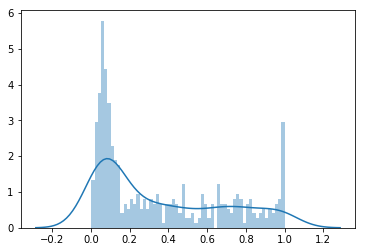

In [3]:
lead_quants=[]
for quant in df0['Percentage_lead']:
    if (quant != 0):
        lead_quants.append(quant)
sns.distplot(lead_quants, bins=60)

Note that there is a very significant peak in the interval [0, 0.2], which could represent a misleading segment of the overall population when performing the lead classification. The samples belonging to this interval are therefore re-labelled as negative (no lead present) to improve the final accuracy.

In [4]:
# Limit set as 0.2
change_count = 0
percentages = np.asarray(df0['Percentage_lead'])
labels=np.asarray(labels)
for indexDF, rowDF in df0.iterrows():
    if (percentages[indexDF] < 0.2):
        labels[indexDF] = 0
        change_count = change_count + 1
print('Changed the label on',change_count,' churches that have below 20% lead')

Changed the label on 549 that have below 20% lead


Printing out a couple of samples as examples:

Working with 2335 images
Image examples: 
fil143A.png


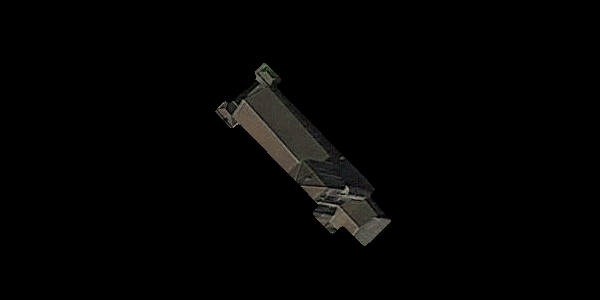

fil143B.png


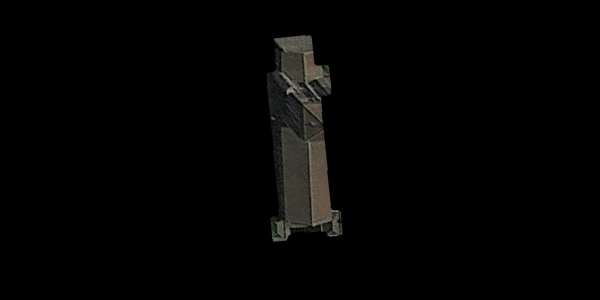

In [5]:
folder = img_dir
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")

for i in range(145, 147):
    print(onlyfiles[i])
    display(_Imgdis(filename=folder + "/" + onlyfiles[i], width=240, height=320))
    

Reshaping the imagery dataset to fit the additional generated imagery with the corresponding labels.

In [6]:
import imageio
import glob
imagery = []

ABC = ['A','B','C']
targets_copy=labels.copy()
labels=[]
for letter in ABC:
    for i in range (df0.shape[0]):
        imname = 'fil' + str(i) + str(letter) + '.png' 
        filename = img_dir + imname
    # for filename in glob.glob('C:/Users/hecto/Documents/TFM/church_imagery/*.png'): #assuming gif
        imraw=imageio.imread(filename)
        im = imraw.reshape([300, 600, 3])
        im2=im.copy()    
        imagery.append(im)
    labels=np.append(labels, targets_copy)

imagery = np.asarray(imagery, dtype=np.uint8)

print ('New size of the imagery:', imagery.shape)
print('Lead present in {} images'.format(np.sum(labels==True)))
print('Lead not present in {} images'.format(np.sum(labels==False)))


New size of the imagery: (2334, 300, 600, 3)
Lead present in 687 images
Lead not present in 1647 images


Printing out the different color spectrums (red, green, blue accordingly) from a random sample of the imagery.

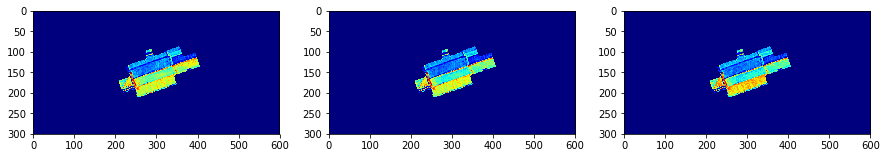

In [7]:
spectrum = imagery[146]
plt.figure(figsize = (5*3, 5*1))
plt.set_cmap('jet')
plt.subplot(1, 3, 1)
plt.imshow(spectrum[:,:,0])
plt.subplot(1, 3, 2)
plt.imshow(spectrum[:,:,1])
plt.subplot(1, 3, 3)
plt.imshow(spectrum[:,:,2])  
plt.show()

Note that the the blue color spectrum is much more representative of the presence of lead than the other two. For this reason we will only use this color spectrum to perform the classification instead of a combination of all three. 

# Pre-processing the data

We shuffle the indexes and normalize the data to pre-process the data for the classification.

In [9]:
# shuffle all indexes
indexes = np.arange(imagery.shape[0])
print('Indexes is', indexes.size)
np.random.shuffle(indexes)
X = imagery[indexes]
y = labels[indexes]

Xblue= X[:,:,:,2]
Xblue= Xblue.reshape(X.shape[0], 300, 600, +1)

# normalization
X = X / 255
Xblue = Xblue / 255


Indexes is 2334


Splitting the dataset into:
    - train set (80%)
    - validation set (10%)
    - test set (10%)

In [10]:
X_train, X_test1, y_train, y_test1 = train_test_split(Xblue, y, test_size=0.2, random_state=33, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test1, y_test1, test_size=0.5, random_state=33, stratify=y_test1)
print("Train set size: {0}, Val set size: {1}, Test set size: {2}".format(len(X_train), len(X_val), len(X_test)))

Train set size: 1867, Val set size: 234, Test set size: 233


# Generating and configuring the classifier

Hyperparameters configuration for the convolutional neural network.

In [11]:
eta = 0.0001
batch_size = 64
epochs = 40
inChannel = 1
x, y = 300, 600
input_img = (x, y, inChannel)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

C:\Users\hecto\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Defining the body of the convolutional neural network to perform the classification.

In [12]:
np.random.seed(7)

# network design
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_img, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
# model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
# model.add(Dropout(0.10))

model.add(Conv2D(64, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(32, activation='relu')) #was 64
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# Running the classification training and prediction

Running the network, logging the history of the classification validation accuracy to keep track of the gradient descent during the training phase.

Train on 1867 samples, validate on 234 samples
Epoch 1/40
1867/1867 [==============================] - 27s 15ms/step - loss: 0.6466 - acc: 0.6936 - val_loss: 0.6140 - val_acc: 0.7051
Epoch 2/40
1867/1867 [==============================] - 17s 9ms/step - loss: 0.5751 - acc: 0.7113 - val_loss: 0.5523 - val_acc: 0.6795
Epoch 3/40
1867/1867 [==============================] - 17s 9ms/step - loss: 0.5057 - acc: 0.7279 - val_loss: 0.5893 - val_acc: 0.7094
Epoch 4/40
1867/1867 [==============================] - 17s 9ms/step - loss: 0.4770 - acc: 0.7343 - val_loss: 0.4835 - val_acc: 0.6838
Epoch 5/40
1867/1867 [==============================] - 17s 9ms/step - loss: 0.4557 - acc: 0.7440 - val_loss: 0.4848 - val_acc: 0.7094
Epoch 6/40
1867/1867 [==============================] - 17s 9ms/step - loss: 0.4435 - acc: 0.7354 - val_loss: 0.5196 - val_acc: 0.6966
Epoch 7/40
1867/1867 [==============================] - 17s 9ms/step - loss: 0.4441 - acc: 0.7525 - val_loss: 0.4821 - val_acc: 0.7051
Epoch 8

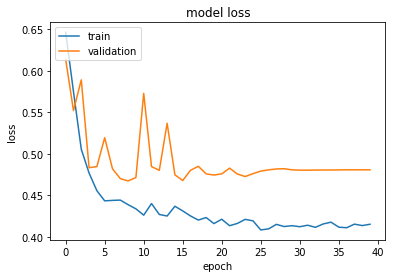

233/233 [==============================] - 1s 5ms/step

 Training acc :  77.02196036102814 %

 Validation acc :  71.3675214184655 %

 Test acc :  79.82832625700169 %


In [13]:
# optimization setup
sgd = SGD(lr=0.0045, momentum=0.9, nesterov=True)
#0.002
#0.0045 dropout 10%
rmsprop = RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
model.compile(
    loss='binary_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training
history = model.fit(
            X_train, 
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[mcp_save, reduce_lr_loss],
            shuffle=True,
            verbose=1)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# evaluate the model
Tra_scores = model.evaluate(X_train, y_train)
Val_scores = model.evaluate(X_val, y_val)
Tes_scores = model.evaluate(X_test, y_test)
tra_accuracy = Tra_scores[1]*100
val_accuracy = Val_scores[1]*100
tes_accuracy = Tes_scores[1]*100
accuracy_name = model.metrics_names[1]



# y_pred=model.predict(X_test)
# y_pred = y_pred.astype(int)
# y_pred =(y_pred>0.5)
# y_test=y_test.tolist()
# y_test=np.asarray(y_test).astype('uint8')
# y_pred=np.asarray(y_pred).astype('uint8')

# matrix = confusion_matrix(y_test, y_pred)
# print(" -> Confusion Matrix: \n", matrix)

# df_cm = pd.DataFrame(matrix, range(2), range(2))
# plt.figure(figsize = (10,7))
# sn.set(font_scale=1.4)#for label size
# sn.heatmap(df_cm, annot=True,annot_kws={"size": 20})# font size

Printing out the results of the classifier.

In [3]:
print('\n Training', accuracy_name, ': ', tra_accuracy, '%')
print('\n Validation', accuracy_name, ': ', val_accuracy, '%')
print('\n Test', accuracy_name, ': ', tes_accuracy, '%')

NameError: name 'accuracy_name' is not defined